# EDA Notebook for ODIR Eye Fundus Dataset
1. read csv and map label
2. make csv
3. split data
4. DataLoader & data augment
5. Figure view


In [1]:
import os
import glob
import pandas as pd
import numpy as np
from sklearn.model_selection import StratifiedKFold
from torch.utils.data import DataLoader, Dataset
import torch
from torchvision import transforms as T
from PIL import Image
import cv2
import matplotlib.pyplot as plt
import seaborn as sns

root_dir = os.path.abspath("..")
os.chdir(root_dir)

sns.set_theme(style="whitegrid")
plt.rcParams["figure.figsize"] = (10, 6)



 ## 1. read csv and map label

In [2]:


df = pd.read_csv('./data/ODIR/full_df.csv')

print(df.head())

label_mapping = {
    'N': 0, 'D': 1, 'G': 2, 'C': 3,
    'A': 4, 'H': 5, 'M': 6, 'O': 7
}




   ID  Patient Age Patient Sex Left-Fundus Right-Fundus  \
0   0           69      Female  0_left.jpg  0_right.jpg   
1   1           57        Male  1_left.jpg  1_right.jpg   
2   2           42        Male  2_left.jpg  2_right.jpg   
3   4           53        Male  4_left.jpg  4_right.jpg   
4   5           50      Female  5_left.jpg  5_right.jpg   

                            Left-Diagnostic Keywords  \
0                                           cataract   
1                                      normal fundus   
2  laser spot，moderate non proliferative retinopathy   
3                        macular epiretinal membrane   
4             moderate non proliferative retinopathy   

                Right-Diagnostic Keywords  N  D  G  C  A  H  M  O  \
0                           normal fundus  0  0  0  1  0  0  0  0   
1                           normal fundus  1  0  0  0  0  0  0  0   
2  moderate non proliferative retinopathy  0  1  0  0  0  0  0  1   
3       mild nonproliferative re

## 2. make csv

In [3]:
data_file = './data/ODIR/ODIR-5K/Training Images'
imgs = glob.glob(data_file + '/*.jpg')
imgs_name = [i.split('/')[-1] for i in imgs]


results = {}
for img_name in imgs_name:
    if img_name in df['filename'].values:
        label = df[df['filename'] == img_name]['labels'].values[0]
        results[img_name] = label_mapping[label.strip("[]'\"")]
    else:
        print(f'{img_name} not found.')
datafile = pd.DataFrame(list(results.items()), columns=["filename", "label"])
os.makedirs('./notebook/csv')
datafile.to_csv("./notebook/csv/Overall_label.csv", index=False)

1005_left.jpg not found.
1014_left.jpg not found.
1017_left.jpg not found.
1017_right.jpg not found.
1018_left.jpg not found.
1020_right.jpg not found.
1033_left.jpg not found.
1036_left.jpg not found.
1036_right.jpg not found.
104_left.jpg not found.
104_right.jpg not found.
1061_left.jpg not found.
1062_left.jpg not found.
1065_right.jpg not found.
1066_left.jpg not found.
1077_left.jpg not found.
1087_left.jpg not found.
1087_right.jpg not found.
1089_right.jpg not found.
108_left.jpg not found.
1095_right.jpg not found.
1096_right.jpg not found.
109_left.jpg not found.
109_right.jpg not found.
1101_left.jpg not found.
1101_right.jpg not found.
1116_left.jpg not found.
1121_left.jpg not found.
1123_right.jpg not found.
1127_left.jpg not found.
1130_left.jpg not found.
1131_left.jpg not found.
1131_right.jpg not found.
1134_left.jpg not found.
1134_right.jpg not found.
1137_right.jpg not found.
1140_left.jpg not found.
1140_right.jpg not found.
1142_left.jpg not found.
1145_left.jpg 

FileExistsError: [Errno 17] File exists: './notebook/csv'

 ## 3. split data ( 5 fold )

In [7]:
data = pd.read_csv("./notebook/csv/Overall_label.csv")
fold_number = 5
skf = StratifiedKFold(n_splits=fold_number, shuffle=True, random_state=42)

for fold, (train_val_idx, test_idx) in enumerate(skf.split(data, data["label"]), 1):
    train_val_data = data.iloc[train_val_idx]
    test_data = data.iloc[test_idx]

    skf_val = StratifiedKFold(n_splits=fold_number-1, shuffle=True, random_state=42)
    for _, (train_idx, val_idx) in enumerate(skf_val.split(train_val_data, train_val_data["label"])):
        train_data = train_val_data.iloc[train_idx]
        val_data = train_val_data.iloc[val_idx]
        break

    csv_dir = f'./csv/{fold_number}11/{fold}'
    os.makedirs(csv_dir, exist_ok=True)
    train_data.to_csv(os.path.join(csv_dir,'train.csv'), index=False)
    val_data.to_csv(os.path.join(csv_dir,'val.csv'), index=False)
    test_data.to_csv(os.path.join(csv_dir,'test.csv'), index=False)

 ## 4. Dataset and DataLoader

In [8]:
class ImgDataset(Dataset):
    def __init__(self, csv_path, img_path, split_fold, data_type='train', transform=None):
        super().__init__()
        self.transform = transform if transform else T.Compose([
            T.Resize((300,300)), T.CenterCrop(224), T.ToTensor()
        ])
        df_path = os.path.join(csv_path, str(split_fold), data_type+'.csv')
        df = pd.read_csv(df_path)
        self.file_path = [os.path.join(img_path,i) for i in list(df['filename'])]
        self.labels = list(df['label'])
        self.len = len(self.labels)

    def __len__(self):
        return self.len

    def __getitem__(self, idx):
        img = Image.open(self.file_path[idx]).convert("RGB")
        img = self.transform(img)
        return img, self.labels[idx]

# DataLoader 示例
csv_path = './data/ODIR/csv/311'
img_path = './data/ODIR/ODIR-5K/Training Images'
split_fold = 1

train_transforms = T.Compose([
    T.Resize((256,256)),
    T.RandomRotation(30),
    T.RandomHorizontalFlip(),
    T.RandomVerticalFlip(),
    T.ColorJitter(brightness=0.2, contrast=0.2),
    T.RandomResizedCrop(224, scale=(0.8,1.0)),
    T.ToTensor(),
    T.Normalize([0.5]*3,[0.5]*3)
])

dataset = ImgDataset(csv_path, img_path, split_fold, transform=train_transforms)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True, num_workers=4)

print(len(dataloader))

120


## 5. Figure view

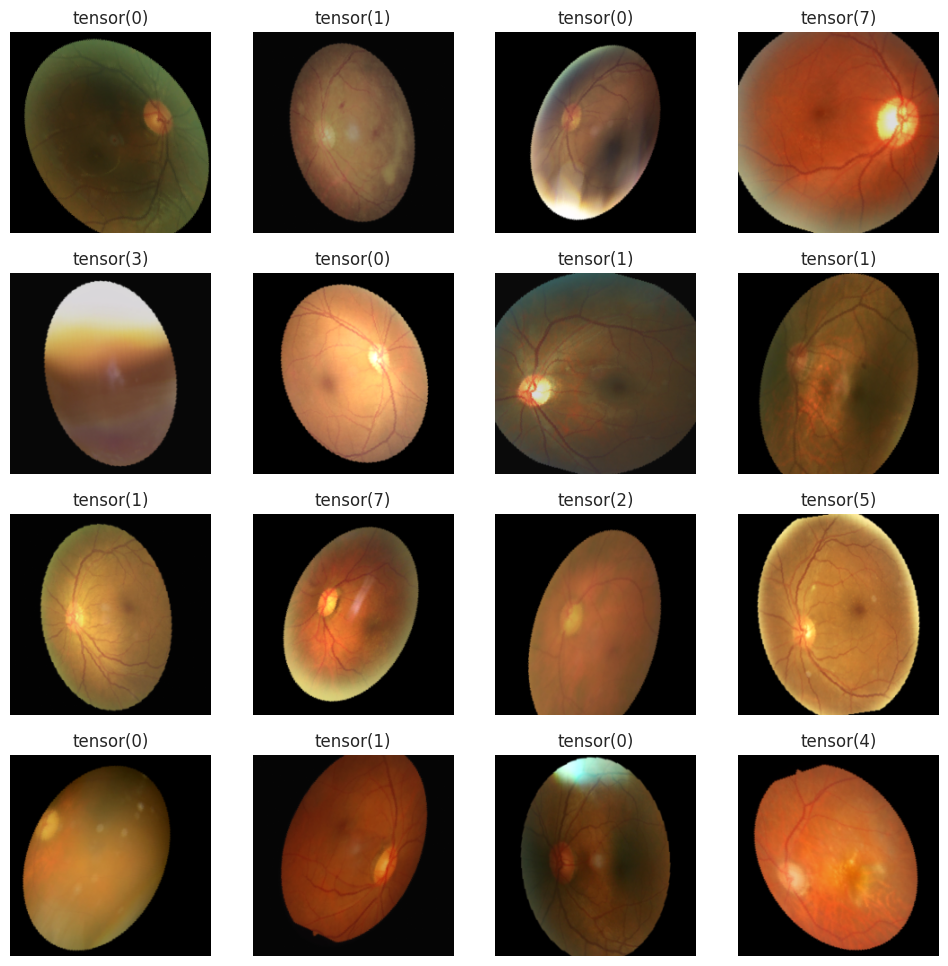

In [9]:
def show_images(images, labels, n=16):
    plt.figure(figsize=(12,12))
    for i in range(min(n,len(labels))):
        plt.subplot(4,4,i+1)
        img = images[i].permute(1,2,0).numpy()
        img = (img*0.5+0.5)  # [-1,1] -> [0,1]
        plt.imshow(img)
        plt.title(labels[i])
        plt.axis('off')
    plt.show()

for imgs, labels in dataloader:
    show_images(imgs, labels)
    break